<a href="https://colab.research.google.com/github/AnanyaAgarwal25/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi** **Layer** **Perceptron**

We are going to import the libraries and modules. Also, the tranform functions used in jax. 

In [7]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

Initialising the network, we are going to define the parameters of mlp. We are also using pytree. It wrap the parameters in some more complex data structures.

In [8]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784,604,512,256,10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(604, 784), (604,)], [(512, 604), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


Predicting the tests with, mlp and the layers associated with it

In [9]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits)

# tests

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(16, 784)
(16, 10)


Using MNIST dataset in the below code, we split the dataset, train and test in 80:20 ratio

In [18]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels
batch_size = 126
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(126, 784) float32 (126,) int64


Analyzing the dataset with the accuracy metrics.

In [13]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size),604,512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.23106566
0.22467418
0.21706791
0.20220514
0.17482798
0.14743456
0.09102332
0.083522394
0.07213022
0.058344644
Epoch 0, train acc = 0.8494499921798706 test acc = 0.8538999557495117
0.050116397
0.054624926
0.045853317
0.040357426
0.043408286
0.03262676
0.030202562
0.030078903
0.044256367
0.03300814
Epoch 1, train acc = 0.8971999883651733 test acc = 0.9027000069618225
0.03687678
0.028381351
0.029302899
0.035063773
0.036650807
0.024094734
0.028363004
0.039429635
0.019543925
0.025435215
Epoch 2, train acc = 0.9112333655357361 test acc = 0.9156000018119812
0.025935728
0.035067227
0.028054846
0.024916915
0.034067176
0.02925146
0.025559187
0.035605513
0.020084603
0.02474287
Epoch 3, train acc = 0.9228000044822693 test acc = 0.924299955368042
0.023701051
0.024868548
0.030381218
0.02479785
0.019505197
0.022321552
0.037149943
0.01803788
0.02659495
0.03894333
Epoch 4, train acc = 0.930733323097229 test acc = 0.9319999814033508


Plotting the image and the curve.

(28, 28)
pred 7
gt 7


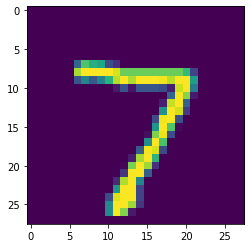

In [14]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)
plt.imshow(img); plt.show()

Manually optimizing the dead neurons.

In [20]:
def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size),604, 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (126, 604/512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

(126, 512)
1
9
11
